# Federated Learning with BraTS 2021 Dataset
This notebook implements a federated learning framework for brain tumor segmentation using the BraTS 2021 dataset.

In [29]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [30]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [31]:
images_path = 'Data/BraTS2021'
IMG_SIZE = 128  # Resize images to 128x128
VOLUME_SLICES = 50  # Number of slices per patient
VOLUME_START_AT = 22  # Start slicing from this index
REDUCE_PATIENTS = False  # Option to reduce the number of patients per hospital
PATIENT_LIMIT = 10  # Number of patients per hospital if REDUCE_PATIENTS is Tru

# Load the dataset file paths
all_patients = [os.path.join(images_path, p) for p in os.listdir(images_path)]
np.random.shuffle(all_patients)

In [32]:
# Split dataset among hospitals (nodes)
nodes = {
    "Hospital_1": all_patients[:len(all_patients)//3],
    "Hospital_2": all_patients[len(all_patients)//3:2*len(all_patients)//3],
    "Hospital_3": all_patients[2*len(all_patients)//3:]
}

In [50]:
# Define Data Generator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(images_path, os.path.basename(i), os.path.basename(i))
            flair = nib.load(f'{case_path}_flair.nii').get_fdata()
            ce = nib.load(f'{case_path}_t1ce.nii').get_fdata()
            seg = nib.load(f'{case_path}_seg.nii').get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        y[y == 4] = 3  # Adjust class values
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        return X / np.max(X), Y

In [51]:
# Distribute dataset into train, validation, and test sets
hospitals_data = {}
for hospital, files in nodes.items():
    np.random.shuffle(files)
    train_split = int(0.7 * len(files))
    val_split = int(0.85 * len(files))
    hospitals_data[hospital] = {
        "train": DataGenerator(files[:150]),
        "val": DataGenerator(files[150:180]),
        "test": DataGenerator(files[180:200])
    }


# Print dataset shapes for each hospital
    print(f"{hospital}: Train={len(hospitals_data[hospital]['train'])}, Val={len(hospitals_data[hospital]['val'])}, Test={len(hospitals_data[hospital]['test'])}")

Hospital_1: Train=150, Val=30, Test=20
Hospital_2: Train=150, Val=30, Test=20
Hospital_3: Train=150, Val=30, Test=20


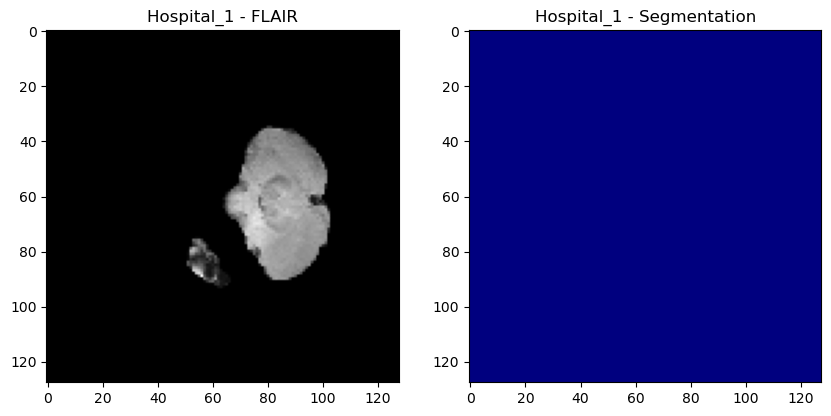

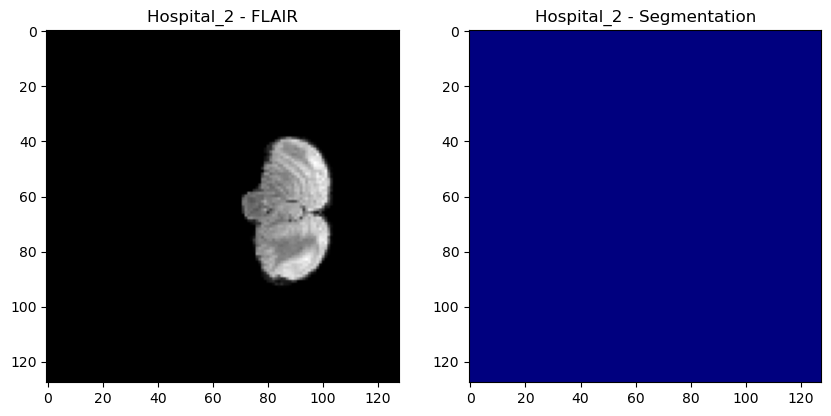

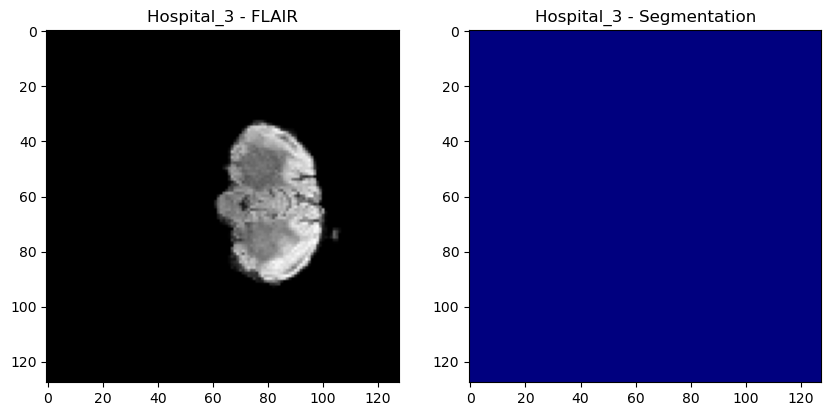

In [52]:
# Visualize Some Slices from Each Hospital
for hospital, data in hospitals_data.items():
    X_sample, y_sample = data['train'].__getitem__(0)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X_sample[0, :, :, 0], cmap='gray')
    ax[0].set_title(f"{hospital} - FLAIR")
    ax[1].imshow(np.argmax(y_sample[0], axis=-1), cmap='jet')
    ax[1].set_title(f"{hospital} - Segmentation")
    plt.show()

In [53]:
## Cell 5: Define UNet model with proper upsampling
def create_unet_model(input_shape=(IMG_SIZE, IMG_SIZE, 2)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(4, (4, 4), strides=(4, 4), activation='softmax', padding='same')(x)  # Proper upsampling
    return keras.Model(inputs, x)

In [54]:
# Initialize models for each hospital
local_models = {}
for hospital in hospitals_data.keys():
    local_models[hospital] = create_unet_model()

In [55]:
num_rounds = 1
global_model = create_unet_model()

def federated_averaging(weight_list):
    avg_weights = []
    for weights in zip(*weight_list):
        avg_weights.append(np.mean(weights, axis=0))
    return avg_weights


In [56]:
for round_num in range(num_rounds):
    local_weights = []
    
    for hospital in hospitals_data.keys():
        print(f"Training {hospital}...")

        # Free memory before training each hospital
        tf.keras.backend.clear_session()

        # Create a fresh model to avoid memory leak
        local_model = create_unet_model()
        local_model.set_weights(global_model.get_weights())
        
        # Compile and train
        local_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
        local_model.fit(hospitals_data[hospital]['train'], epochs=1, validation_data=hospitals_data[hospital]['val'])
        
        # Save trained weights
        local_weights.append(local_model.get_weights())

    new_global_weights = federated_averaging(local_weights)
    global_model.set_weights(new_global_weights)


Training Hospital_1...
  2/150 ━━━━━━━━━━━━━━━━━━━━ 1:30 611ms/step - accuracy: 0.7591 - loss: 1.3858

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
OSError: [WinError 8] Not enough memory resources are available to process this command
Traceback (most recent call last):

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 247, in _finite_generator
    yield self.py_dataset[i]
          ~~~~~~~~~~~~~~~^^^

  File "C:\Users\binwa\AppData\Local\Temp\ipykernel_14848\2993538711.py", line 17, in __getitem__
    X, y = self.__data_generation(Batch_ids)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\binwa\AppData\Local\Temp\ipykernel_14848\2993538711.py", line 31, in __data_generation
    flair = nib.load(f'{case_path}_flair.nii').get_fdata()
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\dataobj_images.py", line 373, in get_fdata
    data = np.asanyarray(self._dataobj, dtype=dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 457, in __array__
    arr = self._get_scaled(dtype=dtype, slicer=())
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 424, in _get_scaled
    scaled = apply_read_scaling(self._get_unscaled(slicer=slicer), scl_slope, scl_inter)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 394, in _get_unscaled
    return array_from_file(
           ^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\volumeutils.py", line 450, in array_from_file
    return np.memmap(infile, in_dtype, mode=mode, shape=shape, order=order, offset=offset)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\numpy\core\memmap.py", line 268, in __new__
    mm = mmap.mmap(fid.fileno(), bytes, access=acc, offset=start)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

OSError: [WinError 8] Not enough memory resources are available to process this command


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_54548]

In [43]:
# Ensure the global model is compiled before evaluation
global_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Evaluate the global model on each hospital's test set
for hospital, data in hospitals_data.items():
    loss, acc = global_model.evaluate(data["test"])
    print(f"Global Model - {hospital}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 444ms/step - accuracy: 0.9918 - loss: 0.0566
Global Model - Hospital_1: Accuracy = 0.9907, Loss = 0.0622
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 574ms/step - accuracy: 0.9968 - loss: 0.0348
Global Model - Hospital_2: Accuracy = 0.9938, Loss = 0.0468
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 722ms/step - accuracy: 0.9832 - loss: 0.0991
Global Model - Hospital_3: Accuracy = 0.9873, Loss = 0.0805


In [45]:
# Ensure the global model is compiled before evaluation
global_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Evaluate on each hospital's test set
global_results = {}
for hospital, data in hospitals_data.items():
    loss, acc = global_model.evaluate(data["test"])
    global_results[hospital] = {"Loss": loss, "Accuracy": acc}
    print(f"Global Model - {hospital}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.9916 - loss: 0.0574
Global Model - Hospital_1: Accuracy = 0.9907, Loss = 0.0622
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.9950 - loss: 0.0418
Global Model - Hospital_2: Accuracy = 0.9938, Loss = 0.0468
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.9808 - loss: 0.1110
Global Model - Hospital_3: Accuracy = 0.9873, Loss = 0.0805


In [47]:
# Ensure local models are compiled before evaluation
local_results = {}
for hospital, model in local_models.items():
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    loss, acc = model.evaluate(hospitals_data[hospital]['test'])
    local_results[hospital] = {"Loss": loss, "Accuracy": acc}
    print(f"Local Model - {hospital}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")

# Compare local vs. global accuracy
for hospital in hospitals_data.keys():
    print(f"{hospital} - Local Model Accuracy: {local_results[hospital]['Accuracy']:.4f}, Global Model Accuracy: {global_results[hospital]['Accuracy']:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - accuracy: 0.7050 - loss: 1.3865
Local Model - Hospital_1: Accuracy = 0.7028, Loss = 1.3865
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.7039 - loss: 1.3864
Local Model - Hospital_2: Accuracy = 0.6957, Loss = 1.3864
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.6876 - loss: 1.3861
Local Model - Hospital_3: Accuracy = 0.6961, Loss = 1.3861
Hospital_1 - Local Model Accuracy: 0.7028, Global Model Accuracy: 0.9907
Hospital_2 - Local Model Accuracy: 0.6957, Global Model Accuracy: 0.9938
Hospital_3 - Local Model Accuracy: 0.6961, Global Model Accuracy: 0.9873


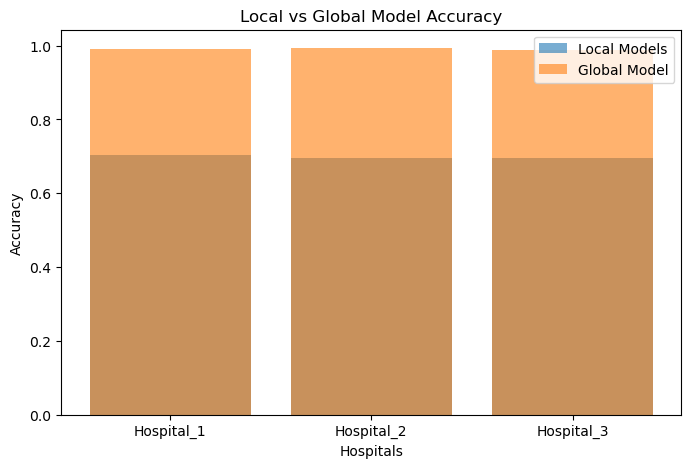

In [48]:
# Extract accuracy values
hospitals = list(hospitals_data.keys())
local_accuracies = [local_results[h]["Accuracy"] for h in hospitals]
global_accuracies = [global_results[h]["Accuracy"] for h in hospitals]

# Plot accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(hospitals, local_accuracies, alpha=0.6, label="Local Models")
plt.bar(hospitals, global_accuracies, alpha=0.6, label="Global Model")
plt.xlabel("Hospitals")
plt.ylabel("Accuracy")
plt.title("Local vs Global Model Accuracy")
plt.legend()
plt.show()


In [49]:
for hospital, data in hospitals_data.items():
    y_true = np.argmax(np.vstack([y for _, y in data["test"]]), axis=-1).flatten()
    y_pred = np.argmax(global_model.predict(data["test"]), axis=-1).flatten()

    fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel(), pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{hospital} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Global Model on Each Hospital")
plt.legend()
plt.show()


C:\Users\binwa\AppData\Local\Temp\ipykernel_14848\2993538711.py:44: RuntimeWarning: invalid value encountered in divide
  return X / np.max(X), Y


ResourceExhaustedError: {{function_node __wrapped__ResizeNearestNeighbor_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[50,128,128,4] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:ResizeNearestNeighbor] name: 